 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 6. MLP Basis**
# Section 7. BackPropagation Implementation

### _Objective_
1. Numpy를 통해, BackPropagation을 구현해 보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [21]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 예제 데이터 ) 암 환자 데이터 셋

In [22]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

--2019-04-03 10:01:19--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.113
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2958 (2.9K) [text/csv]
Saving to: ‘cancer_dataset.csv.2’

cancer_dataset.csv. 100%[===================>]   2.89K  --.-KB/s    in 0.001s  

2019-04-03 10:01:19 (2.10 MB/s) - ‘cancer_dataset.csv.2’ saved [2958/2958]



In [23]:
cancer_df.describe()

,age,tumor_size,label
count,100.000000,100.000000,100.00
mean,4.218584,4.463655,0.45
std,1.949688,2.264897,0.50
min,0.494542,0.656397,0.00
25%,2.750747,2.832193,0.00
50%,3.849528,3.766226,0.00
75%,5.405780,5.921538,1.00
max,9.670666,11.170589,1.00


### 데이터 시각화

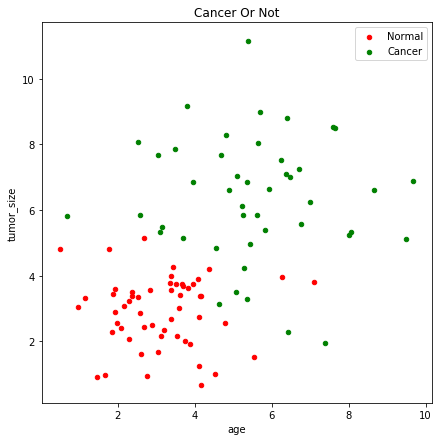

In [24]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

<br><br>

# \[ 1. 2층 신경망 구현하기 \]

----

----

> *Chapter 3에서 구현하였던 2층짜리 신경망을 구현해 보도록 하겠습니다. *<br>


<br>

## 1. Layer의 구조
---
* Layer은 크게 3가지로 나누어서 구현하겠습니다.

    1. forward : 순전파 부분
    2. backward : 역전파 부분
    3. update : gradient Descent로 update해야 하는 부분


![Imgur](https://i.imgur.com/HXHigUH.png)

In [25]:
class Layer:
    def forward(self, x):
        """
        해당 Operation의 순전파를 계산
        """
        raise NotImplementedError
        
    def backward(self, grad):
        """
        해당 Operation의 역전파를 계산
        """
        raise NotImplementedError
        
    def update(self, learning_rate):
        """
        [optional]
        해당 Layer에 Weight가 있다면,
        w_old = w_new - learning_rate * dw
        """
        pass

코드의 수식은 아래와 같습니다.

$$
z1 = X\cdot W1 + b1 \\
a1 = relu(z1)  \\
z2 = a1 \cdot W2 + b2  \\
\hat y = sigmoid(z2) \\
CrossEntropy = -y_{true}log(y_{pred})+(1-y_{true})log(1-y_{pred})
$$



## 2. Layer 구현하기
---


### (1) Logit Layer 만들기

In [26]:
class LogitLayer(Layer):
    def __init__(self, weight, bias):
        # 초기 weight, bias 값
        self.weight = weight
        self.bias = bias
        # Gradient Descent할 때 필요한 값
        self.X = 0
        self.delta_W = 0
        self.delta_B = 0
    
    def forward(self, X):
        out = np.matmul(X,self.weight) + self.bias
        self.X = X
        return out
        
    def backward(self, grad):
        self.delta_W = np.matmul(self.X.T, grad)
        self.delta_B = np.sum(grad, axis=0)
        return np.matmul(grad, self.weight.T)
    
    def update(self, learning_rate):
        self.weight -= learning_rate * self.delta_W
        self.bias -= learning_rate * self.delta_B

### (2) Relu Layer 만들기

In [35]:
class ReluLayer(Layer):
    def __init__(self):
        # Gradient Descent할 때 필요한 값
        self.out = 0
    
    def forward(self, X):
        self.out = np.maximum(X,0)
        return self.out
        
    def backward(self, grad):
        mask = self.out>0
        return grad * mask

### (3) Sigmoid-With-Loss Layer 만들기

In [36]:
class SigmoidWithLossLayer(Layer):
    def __init__(self):
        # Gradient Descent할 때 필요한 값
        self.y_pred = 0
        self.y_true = 0
    
    def forward(self, X, y_true):
        y_pred = 1/(1+np.exp(-X))
        loss = -(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
        
        self.y_pred = y_pred
        self.y_true = y_true
        return loss
        
    def backward(self, grad):
        loss_gradient = self.y_pred - self.y_true
        
        dataset_size = self.y_pred.shape[0]
        loss_gradient = loss_gradient / dataset_size
        return grad * loss_gradient

<br>

## 3. Network 구현
---


In [37]:
class TwoLayerNetwork:
    def __init__(self,num_input=2,num_hidden=200,num_output=1):
        w1 = np.random.normal(0,scale=0.1, 
                              size=(num_input,num_hidden))
        b1 = np.zeros((num_hidden,))
        w2 = np.random.normal(0,scale=0.1,
                              size=(num_hidden,num_output))
        b2 = np.zeros((num_output))
        
        self.layers = []

        self.layers.append(LogitLayer(w1,b1))
        self.layers.append(ReluLayer())        
        self.layers.append(LogitLayer(w2,b2))
        
        self.loss_layer = SigmoidWithLossLayer()
        
    def forward_layer(self, X):
        X_ = X
        for layer in self.layers:
            # 순방향으로 연산 진행
            X_ = layer.forward(X_)
        return X_
        
    def backward_layer(self, grad):
        for layer in self.layers[::-1]:
            # 역방향으로 연산 진행
            grad = layer.backward(grad)
    
    def predict(self, X):
        out = self.forward_layer(X)
        y_pred = 1/(1+np.exp(-out))
        return y_pred
    
    def train(self, X, y, learning_rate=0.01):
        # 순방향으로 Loss 값 연산
        out = self.forward_layer(X)
        loss = self.loss_layer.forward(out, y)
        
        # Backpropagation 진행
        grad = 1
        grad = self.loss_layer.backward(grad)
        self.backward_layer(grad)
        
        # Gradient Descent 알고리즘으로 weight 갱신
        for layer in self.layers:
            layer.update(learning_rate)
            
        return np.mean(loss)

<br><br>

# \[ 2. 2층 신경망 학습시키기 \]

----

----

> *구현한 신경망을 학습시켜 결과를 반환해보도록 하겠습니다.*<br>


### (1) 모델 불어오기

In [38]:
model = TwoLayerNetwork()

### (2) 데이터 불러오기

In [39]:
cancer_df = (cancer_df-cancer_df.min())/(cancer_df.max()-cancer_df.min())

x_1 = cancer_df.tumor_size
x_2 = cancer_df.age
data_X = np.stack([x_1,x_2],axis=1)

data_Y = cancer_df.label.values.reshape(-1,1)

### (3) 모델 학습하기

In [50]:
loss_history = []
for epoch in range(50000):
    loss_value = model.train(data_X, data_Y,0.01)
    
    loss_history.append(loss_value)

/Users/ksj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/ksj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


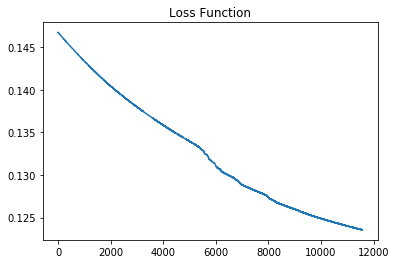

In [51]:
plt.title("Loss Function")
plt.plot(loss_history)
plt.show()

### (4) 결과 확인하기

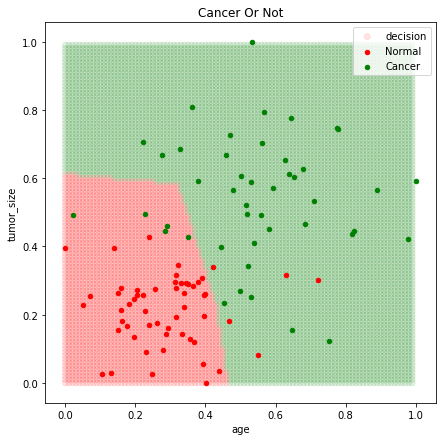

In [52]:
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs = np.stack([x1s.ravel(),x2s.ravel()],axis=1)

results = model.predict(xs)

colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1],c=colors,alpha=0.1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(["decision",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---